# Purpose

This notebook develops a model to predict whether a 
certain promotional offer will motivate buying behavior on an e-commerce site.

In this notebook, we take a small set of the raw input, transform it,
and then work with a field-aware factorization machine (FFM) model directly.

## Data set

The data set is from the [Kasandr UCI data set](https://archive.ics.uci.edu/ml/datasets/KASANDR#).  This is a public data set.  Per the attribution policies, we cite the following paper for this data set:

    Sumit Sidana, Charlotte Laclau, Massih-Reza Amini, Gilles Vandelle, and Andre Bois-Crettez. 'KASANDR: A Large-Scale Dataset with Implicit Feedback for Recommendation', SIGIR 2017. 

The data set is already divided into train and test sets.  The train set has 15,844,718 samples.  The test set has 1,919,562 samples.  That's a total of 17,764,280 samples, with a 90/10 train/test split.

The schema is:

* Features
    * userid: Categorical
    * offerid: Categorical
    * countrycode: Categorical
    * category: Integer (but seems to be encoded, so we'll treat it as categorical)
    * merchant: Integer (but seems to be encoded, so we'll treat it as categorical)
    * utcdate: Timestamp, format '2016-06-01 02:00:17.0'
*  Label: promotion generated response: Binary, 0 or 1 

The country code is not useful, as the entire data set is for Germany.

In [2]:
# Imports
import boto3
import sagemaker
import sagemaker.amazon.common as smac
from sagemaker.predictor import json_deserializer
from sagemaker import get_execution_role

import numpy as np
from scipy.sparse import lil_matrix
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
import scipy
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score

from tffm import TFFMRegressor
import tensorflow as tf

import os.path
import csv, io, json

/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# Bucket with raw data
bucket = 'promo-dataprep'
prefix = 'data'
train_file = 'train_de.csv'
test_file = 'test_de.csv'

In [4]:
# set up boto for s3 access
role = get_execution_role()
s3 = boto3.resource('s3')

# download inputs
if os.path.isfile(train_file) and os.path.exists(train_file):
    print("{0} already exists, skipping".format(train_file))
else:
    s3.Bucket(bucket).download_file("{0}/{1}".format(prefix, train_file), train_file)
if os.path.isfile(test_file) and os.path.exists(test_file):
    print("{0} already exists, skipping".format(test_file))
else:
    s3.Bucket(bucket).download_file("{0}/{1}".format(prefix, test_file), test_file)

train_de.csv already exists, skipping
test_de.csv already exists, skipping


## Read CSV data

In [5]:
# read train data set
train_df = pd.read_csv(train_file,
                       parse_dates = {'utcdate' : [5, 6]}, infer_datetime_format=True,
                       skiprows = 1, sep='\s+', 
                       header = None, names = ['userid', 'offerid', 'countrycode', 'category', 'merchant', 'date0', 'date1', 'rating'],
                       dtype={'userid': 'category', 'offerid': 'category', 'countrycode': 'category',
                                     'category': 'category', 'merchant': 'category', 
                                     'date0': 'str', 'date1': 'str', 'utcdate': 'datetime64', 'rating': 'int64'})
print("Read train data")

# read test data set
test_df = pd.read_csv(test_file,
                       parse_dates = {'utcdate' : [5, 6]}, infer_datetime_format=True,
                       skiprows = 1, sep='\s+', 
                       header = None, names = ['userid', 'offerid', 'countrycode', 'category', 'merchant', 'date0', 'date1', 'rating'],
                       dtype={'userid': 'category', 'offerid': 'category', 'countrycode': 'category',
                                     'category': 'category', 'merchant': 'category', 
                                     'date0': 'str', 'date1': 'str', 'utcdate': 'datetime64', 'rating': 'int64'})
print("Read test data")

Read train data
Read test data


## Preparation

In [6]:
# drop timestamp
train_df_for_model = train_df.drop('utcdate', 1)
test_df_for_model = test_df.drop('utcdate', 1)

# rename label
train_df_for_model = train_df_for_model.rename(columns={"rating": "label"})
test_df_for_model = test_df_for_model.rename(columns={"rating": "label"})

# rename merchant to product
train_df_for_model = train_df_for_model.rename(columns={"merchant": "product"})
test_df_for_model = test_df_for_model.rename(columns={"merchant": "product"})

train_df_for_model.dtypes

userid         category
offerid        category
countrycode    category
category       category
product        category
label             int64
dtype: object

In [7]:
# encode data - merge first so the encoding is done consistently
merged_data = pd.concat([train_df_for_model, test_df_for_model], ignore_index=True)
print("Size of merged data: {0}".format(merged_data.shape))

Size of merged data: (17764278, 6)


In [8]:
# take first 50,000 rows to avoid memory issues
transformed_data = pd.get_dummies(merged_data.sample(50000))
print("Size of transformed data: {0}".format(transformed_data.shape))

Size of transformed data: (50000, 62521)


In [9]:
y = np.array(transformed_data['label'].astype('float32').as_matrix())

# drop label - we store this separately as the output label
transformed_data.drop(['label'], 1, inplace=True)

X = np.array(transformed_data).astype('float32')
X = np.nan_to_num(X)

# Split data into train, test
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)
print("Size of training data: {0} ({1})".format(X_tr.shape, y_tr.shape))
print("Size of test data: {0} ({1})".format(X_te.shape, y_te.shape))

# convert to sparse matrix
X_tr_sparse = scipy.sparse.csr_matrix(X_tr)
X_te_sparse = scipy.sparse.csr_matrix(X_te)
print("Size of sparse training data: {0} ({1})".format(X_tr_sparse.shape, y_te.shape))
print("Size of sparse test data: {0} ({1})".format(X_te_sparse.shape, y_te.shape))

Size of training data: (40000, 62520) ((40000,))
Size of test data: (10000, 62520) ((10000,))
Size of sparse training data: (40000, 62520) ((10000,))
Size of sparse test data: (10000, 62520) ((10000,))


In [10]:
# convert to protobuf and save to s3
def writeDatasetToProtobuf(X, Y, bucket, prefix, key):
    buf = io.BytesIO()
    smac.write_spmatrix_to_sparse_tensor(buf, X, Y)
    buf.seek(0)
    obj = '{}/{}'.format(prefix, key)
    boto3.resource('s3').Bucket(bucket).Object(obj).upload_fileobj(buf)
    return 's3://{}/{}'.format(bucket,obj)
    
train_data = writeDatasetToProtobuf(X_tr_sparse, y_tr, bucket, 'train-small', 'train.protobuf')    
test_data  = writeDatasetToProtobuf(X_te_sparse, y_te, bucket, 'train-small', 'test.protobuf')   
print("S3 training data: {0}".format(train_data))
print("S3 test data: {0}".format(test_data))

S3 training data: s3://promo-dataprep/train-small/train.protobuf
S3 test data: s3://promo-dataprep/train-small/test.protobuf


## Train model

In [11]:
model = TFFMRegressor(
    order=3,
    rank=7,
    optimizer=tf.train.AdamOptimizer(learning_rate=0.1),
    n_epochs=50,
    batch_size=-1,
    init_std=0.001,
    input_type='sparse'
)

model.fit(X_tr_sparse, y_tr, show_progress=True)

100%|██████████| 50/50 [00:02<00:00, 21.08epoch/s]


## Get predictions

In [12]:
predictions = model.predict(X_te_sparse)
model.destroy()

### Classification metrics

In [13]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, average_precision_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.metrics import precision_score, precision_recall_fscore_support, recall_score
predvec = np.where(predictions > 0.5, 1, 0)
print('Weighted F1: {}'.format(f1_score(y_te, predvec,average='weighted')))
print('Accuracy: {}'.format(accuracy_score(y_te, predvec)))
print('Weighted ROC: {}'.format(roc_auc_score(y_te, predvec, average='weighted')))
print('Classification report: {}'.format(classification_report(y_te, predvec)))
print(pd.crosstab(np.array(y_te), predvec, rownames=['actuals'], colnames=['predictions']))

Weighted F1: 0.919082637191
Accuracy: 0.936
Weighted ROC: 0.591242575703
Classification report:              precision    recall  f1-score   support

        0.0       0.94      0.99      0.97      9294
        1.0       0.66      0.19      0.30       706

avg / total       0.92      0.94      0.92     10000

predictions     0    1
actuals               
0.0          9226   68
1.0           572  134


## Save headers to S3

In [14]:
headers = list(transformed_data.columns.values)
with open('headers-small.csv', 'w') as csvfile:
    hwriter = csv.writer(csvfile, delimiter=' ',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for h in headers:
        hwriter.writerow([h])
boto3.resource('s3').Bucket(bucket).Object('train-small/headers.csv').upload_file('headers-small.csv')

## Get most popular offer IDs

### Offer ID distribution¶

We'll start by identifying the unique offer codes. There are over 2 million of them.

In [15]:
unique_offers = train_df.offerid.unique()
unique_offers.shape

(2158859,)

Let's look at the distribution of the offers. How many of the offer codes are frequently used? When we look at the 'max' value below, note that it is substantially higher than the 75th or even the 99th percentile.

In [16]:
unique_counts = train_df.offerid.value_counts()
unique_counts.describe()

count    2.158859e+06
mean     7.339394e+00
std      1.577933e+02
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      5.000000e+00
max      5.964200e+04
Name: offerid, dtype: float64

In [17]:
unique_counts.quantile(0.99)

69.0

Now note that the skew is large and positive, indicating that the distribution is skewed to the right. The kurtosis is also quite large, indicating a sharp peak.

In [18]:
unique_counts.skew()

277.4027482180016

In [20]:
unique_counts.kurtosis()

86665.7693310115

In [21]:
unique_counts.head(20)

0f2fcf95319f5c1e5745371351f521e5    59642
19754ec121b3a99fff3967646942de67    58132
60253e351dee27e77cd50366585517a3    57969
5e378677ca9bb41114562e84001c8516    57940
be83df9772ec47fd210b28091138ff11    57898
3735290a415dc236bacd7ed3aa03b2d5    55554
a5fc37404646ac3d34118489cdbfb341    51790
3c9af92d575a330167fb61dda93b5783    50633
c5f63750c2b5b0166e55511ee878b7a3    46795
241145334525b9b067b15de4fd7a0df1    43875
0c2c89e5fe431aae53fb1ae058770fa2    42495
5ac4398e4d8ad4167a57b43e9c724b18    42415
eb0389774fca117ee06c5c02a6ba76af    42121
ccbdecfb71d4a0a7e836a4a4b1e69c97    41406
fe8efbbd8879b615478cf7314b3b87ba    41296
0576e74e809b3b6f04db1fd98c8c9afb    35437
ebb77a97cfdfd01c8b2f5cbffb1d5627    34877
6b989e6ea6d423160c8b30beb8240946    34628
72d34a12b35de79a46de4fa2298a349b    33650
56691dbb7196e6114c95306094239118    31690
Name: offerid, dtype: int64

### Interpretation

We conclude that the offer ID counts are weighted very heavily towards only a relative few of the offer IDs, producing a distribution that is very heavy near the origin with a long tail. (Keep in mind that the offer counts are in descending order.)

Let's see what a sample of 50 of the most common offers looks like.


In [22]:
# Generate rolling total of first 'N' elements
cumulative_unique_counts = unique_counts.head(50).expanding().apply(sum)

# Divide the rolling totals by the total sample count
pct_of_total = cumulative_unique_counts.div(unique_counts.sum())

# The maximum (last) value shows how much of the total count we've incorporated with only 50 offer IDs.  
max(pct_of_total)


0.08321852640220712

Ok - 50 offers (or about 0.0025% of the total offers) accounts for over 8% of the data set. Let's visualize about 200 offers and double check the distribution.

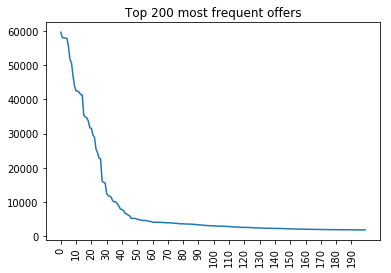

In [24]:
import matplotlib.pyplot as plt
interesting_counts = unique_counts.head(200)
interesting_counts.plot(xticks=range(0,interesting_counts.shape[0],10), rot=90, use_index=False,
                       title='Top 200 most frequent offers')

Indeed, the there is a sharp dropoff somewhere in the 30-50 index.